In [11]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
# http://www2.informatik.uni-freiburg.de/~cziegler/BX/
user = pd.read_csv('BX-Users.csv', sep = ';', error_bad_lines=False, encoding = "latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep = ';', error_bad_lines=False, encoding = "latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']
df = pd.merge(user, rating, on = 'userID', how = 'inner')
df.drop(['Location', 'Age'], axis = 1, inplace = True)
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [3]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

data = df['bookRating'].value_counts().sort_index(ascending = False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )

# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))

# Create plot
fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

In [4]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

In [5]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending = False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

In [6]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper = 50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

In [7]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending = False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

In [8]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


In [9]:
reader = Reader(rating_scale = (0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [12]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), 
                  KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures = ['RMSE'], cv = 3, verbose = False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [13]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [14]:
surprise_results

test_rmse   fit_time  test_time
Algorithm                                       
BaselineOnly      3.378833   0.389315   0.628160
CoClustering      3.465455   5.182371   0.728970
SlopeOne          3.475054   1.347943   8.462607
KNNWithMeans      3.489843   1.445718  11.994519
KNNBaseline       3.493302   1.743739  14.460991
KNNWithZScore     3.510164   1.897875  13.134319
SVD               3.541379  11.614811   0.734250
KNNBasic          3.725737   1.373086  10.279936
NormalPredictor   4.673078   0.290848   0.621920

In [15]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options = bsl_options)
cross_validate(algo, data, measures = ['RMSE'], cv = 3, verbose = False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.38204685, 3.37665327, 3.3709448 ]),
 'fit_time': (0.20814943313598633, 0.2390613555908203, 0.24229693412780762),
 'test_time': (0.5166032314300537, 0.47858214378356934, 0.5836482048034668)}

In [16]:
trainset, testset = train_test_split(data, test_size = 0.25)
algo = BaselineOnly(bsl_options = bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3854


3.3854056671203687

In [17]:
# Reference: https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns = ['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by = 'err')[:10]
worst_predictions = df.sort_values(by = 'err')[-10:]

print("Best predictions: \n", best_predictions)
print("Worst predictions: \n", worst_predictions)

Best predictions: 
           uid         iid  rui  est                    details   Iu  Ui  err
29804  242824  0671027123  0.0  0.0  {'was_impossible': False}  121  26  0.0
18273  189334  0151002290  0.0  0.0  {'was_impossible': False}  102  31  0.0
34163  242824  0515124893  0.0  0.0  {'was_impossible': False}  121  48  0.0
28033  166123  0425180964  0.0  0.0  {'was_impossible': False}  189  53  0.0
18248  235842  0316693286  0.0  0.0  {'was_impossible': False}  100  28  0.0
24039  115120  051510521X  0.0  0.0  {'was_impossible': False}  226  32  0.0
6157   102967  0449225151  0.0  0.0  {'was_impossible': False}  385  35  0.0
18290   55492  051511054X  0.0  0.0  {'was_impossible': False}  380  25  0.0
3036   245963  0446360589  0.0  0.0  {'was_impossible': False}  139  81  0.0
3047   145431  0440218535  0.0  0.0  {'was_impossible': False}   62  50  0.0
Worst predictions: 
           uid         iid   rui       est                    details   Iu  Ui  \
15942   77940  0671027581  10.0

<IPython.core.display.Javascript object>


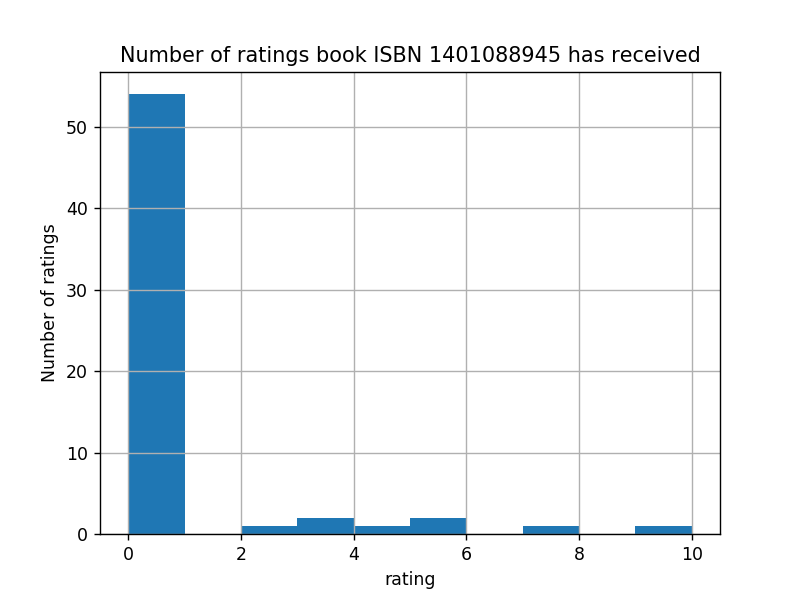

In [19]:
import matplotlib.pyplot as plt
%matplotlib notebook
df_new.loc[df_new['ISBN'] == '1401088945']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 1401088945 has received')
plt.show()